<a href="https://colab.research.google.com/github/AndyCatruna/DSM/blob/main/Lab_02_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

In this lab we will explore Convolutional Neural Networks for image classification.

## Convolution Operation

<img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif?20190413174630" />

The problems of using fully connected neural networks for processing images:
- The image needs to be transformed into a vector - spatial information is discarded;
- Each neuron of the first layer is connected to all pixel values of the image - a lot of parameters for a single layer

Main ideas of CNN:
- Each neuron looks only at a local window of the input
- You slide a small kernel (set of weights) across the whole image - the same weights are re-used for the whole image
- You utilize different kernels for extracting different features as each set of weights is looking for something else

In the following visualization:
- The green matrix - input
- Yellow matrix that slides across the image - the kernel (set of weights) - trainable
- The result - feature map

<img src="https://miro.medium.com/v2/resize:fit:1052/0*jLoqqFsO-52KHTn9.gif"/>

- The kernel has the same channel size as the input
- The input does not have to be an image - it just has to be an image-like structure
- We stack the resulting feature maps of each kernel convolution into an image-like structure - so that we can apply other convolutions to it and extract more meaningful features

<img src="https://animatedai.github.io/media/convolution-animation-3x3-kernel.gif" width=700/>

## Pooling

- We utilize **pooling layers** to downsample the spatial size (height and width) while keeping the relevant information.
- Usually there are no trainable parameters in this layer - it is just used for **efficiency**.

<img src="https://wikidocs.net/images/page/164835/Fig_03.png" width=500/>

Usual types of pooling:

<img src="https://miro.medium.com/v2/resize:fit:1200/0*lIcR0gOMK0xzTr6_.png" />

You can check out the types of pooling layers available in PyTorch [here](https://pytorch.org/docs/stable/nn.html#pooling-layers)

## Convolutional Neural Network

- A CNN is composed of convolution layers + activation functions + some pooling layers
- For classification a fully connected network is utilized - its input is the last set of feature maps obtained by the CNN layers

<img src="https://miro.medium.com/v2/resize:fit:1400/1*vkQ0hXDaQv57sALXAJquxA.jpeg" />

## CNNs in PyTorch

Necessary imports for this lab

In [90]:
import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

We will use the CIFAR10 dataset which contains 32x32 images of 10 different classes. You can read about the dataset [here](https://www.cs.toronto.edu/~kriz/cifar.html)

In [91]:
# for Exercise 2 - Add more transforms - data augmentations (only for training samples)
train_transform = transforms.Compose(
    [
      # For Exercise 2 - Add image transforms here before ToTensor()
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(15),
      
      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

# The batch size is the number of images the model processes in parallel
# We use shuffle for training as we don't want the model to see the images in the same order
trainloader = DataLoader(trainset, batch_size=256,
                                          shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

# For testing we don't have to shuffle the data
testloader = DataLoader(testset, batch_size=256,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We plot some images from the dataset in order to get an idea of how they look.

    ship      dog    truck    horse     frog     ship      car      dog


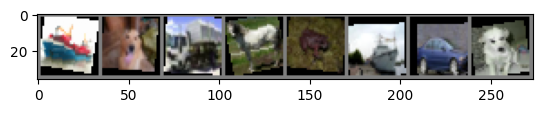

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

We define the device on which we will train the models. For this lab you should have GPU execution enabled. Training the models on cpu will take too much time.

If the models still take too much time to train, you can try to increase the batch size value in the dataloaders (if you increase it too much you might get "Out of memory error").

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We define a training epoch in which we iterate through all the data in the training set and update the model.

A model is usually trained for multiple epochs - it sees the training data multiple times.

In [94]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    # We set the model to be in training mode
    model.train()

    total_train_loss = 0.0
    dataset_size = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    # We iterate through all batches - 1 step is 1 batch of batch_size images
    for step, (images, labels) in bar:
        # We take the images and their labels and push them on GPU
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Reset gradients
        optimizer.zero_grad()

        # Obtain predictions
        pred = model(images)

        # Compute loss for this batch
        loss = criterion(pred, labels)

        # Compute gradients for each weight (backpropagation)
        loss.backward()

        # Update weights based on gradients (gradient descent)
        optimizer.step()

        # We keep track of the average training loss
        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)

    return epoch_loss

We define the validation function in which the model is tested on unseen images.

The validation function looks similar to the training one, except we do not compute gradients or do any gradient descent.

Ideally, we should evaluate the model every few training epochs to see how the model generalizes to new examples.

In [95]:
def valid_epoch(model, dataloader, device, criterion, epoch):
    # We set the model in evaluation mode
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    # We keep track of correct predictions
    correct = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        # The raw output of the model is a score for each class
        # We keep the index of the class with the highest score as the prediction
        _, predicted = torch.max(pred, 1)

        # We see how many predictions match the ground truth labels
        correct += (predicted == labels).sum().item()

        # We compute evaluation metrics - loss and accurarcy
        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss

We define the function that receives the model and trains it with an optimizer and loss function (criterion) for a number of epochs.

In [96]:
def run_training(model, criterion, optimizer, num_epochs):
    # Check if we are using GPU
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    # For keeping track of the best validation accuracy
    top_accuracy = 0.0

    # We train the emodel for a number of epochs
    for epoch in range(num_epochs):

        train_loss = train_epoch(model, trainloader, device, optimizer, criterion, epoch)

        # For validation we do not keep track of gradients
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, testloader, device, criterion, epoch)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

#### Fully Connected Neural Network

We first train a fully connected network (which we played with in Lab 1) on the images to compare it with CNN models.

The fully connected neural network is not a very wise choice for images because we lose spatial information.

In [97]:
class FCNNet(nn.Module):
    def __init__(self):
        super(FCNNet, self).__init__()

        # Linear layers
        # in_features of first layer should correspond to size of images - 3 channels, height 32, width 32
        # out_features of last layer should correspond to number of classes - 10

        self.fc1 = nn.Linear(in_features=3 * 32 * 32, out_features=360)
        self.fc2 = nn.Linear(in_features=360, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=84)
        self.fc4 = nn.Linear(in_features=84, out_features=10)

        # Activation function - can be replaced by other better functions (GELU, Mish etc.)
        self.activation = nn.ReLU()

    def forward(self, x):
        # We transform the image into a 1D vector of size 3 * 32 * 32
        x = x.view(-1, 3 * 32 * 32)

        # Remember - we use activation functions after each linear layer (except the last one)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))

        # Output is 10 scores, one for each class
        x = self.fc4(x)

        return x

We construct the model and push it on GPU

In [98]:
model = FCNNet()
model.to(device)

FCNNet(
  (fc1): Linear(in_features=3072, out_features=360, bias=True)
  (fc2): Linear(in_features=360, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (activation): ReLU()
)

We define the training helpers - hyperparameters, loss, optimizer

In [99]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

# Loss - dependinng on the task you should change this
criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We run the full training

In [100]:
run_training(model, criterion, optimizer, epochs)

100%|██████████| 40/40 [00:02<00:00, 16.88it/s, Epoch=0, Valid_Acc=40.1, Valid_Loss=1.67]
Validation Accuracy Improved (0.0 ---> 40.11)

100%|██████████| 40/40 [00:02<00:00, 14.88it/s, Epoch=1, Valid_Acc=41, Valid_Loss=1.65]  
Validation Accuracy Improved (40.11 ---> 41.01)

100%|██████████| 40/40 [00:01<00:00, 20.36it/s, Epoch=2, Valid_Acc=42.1, Valid_Loss=1.6] 
Validation Accuracy Improved (41.01 ---> 42.09)

100%|██████████| 40/40 [00:01<00:00, 20.46it/s, Epoch=3, Valid_Acc=42.9, Valid_Loss=1.61]
Validation Accuracy Improved (42.09 ---> 42.85)

100%|██████████| 40/40 [00:01<00:00, 20.11it/s, Epoch=4, Valid_Acc=42.9, Valid_Loss=1.56]
Validation Accuracy Improved (42.85 ---> 42.88)

100%|██████████| 40/40 [00:02<00:00, 16.61it/s, Epoch=5, Valid_Acc=44.5, Valid_Loss=1.56]
Validation Accuracy Improved (42.88 ---> 44.55)

100%|██████████| 40/40 [00:01<00:00, 20.08it/s, Epoch=6, Valid_Acc=45.3, Valid_Loss=1.54]
Validation Accuracy Improved (44.55 ---> 45.3)

100%|██████████| 40/40 [00:02<

#### Convolutional Neural Network

We will construct convolutional neural network. We use:
- [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to define a convolutional layer. It has the following important arguments:
  - in_channels - number of channels in input (for images it should be 3)
  - out_channels - the number of feature maps to be produced by the layer - how many features you want to extract
  - **in_channels of a inner layer should correspond to out_channels of previous layer**
  - kernel_size - the size of the matrix of weights that slides across the input
  - There are [other arguments]((https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) that you will get familiar with in the future
- [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) to define a Max Pooling layer
- [Activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)


We will build a CNN that has:
- 2 convolutional layers with kernels of size 5x5
- Max Pooling - to downsample spatial dimensions - you don't have to use it after each convolutional layer
- A fully connected network that will
  - Take as input the features that were extracted by the convolutional layers
  - Output a score for each class

In [101]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)

        # Second conv layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Pooling layer - used after both layers of convolution
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Linear layers of the fully connected classifier
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        # Activation function - can be replaced by other better functions (GELU, Mish etc.)
        self.activation = nn.ReLU()

    def forward(self, x):
        ### Convolutional Part

        # input - x shape - (3,32,32)

        x = self.activation(self.conv1(x))
        # After conv - x shape - (6,28,28)

        x = self.pool(x)
        # After pooling - x shape - (6,14,14)

        x = self.activation(self.conv2(x))
        # After conv - x shape - (16,10,10)

        x = self.pool(x)
        # After pooling - x shape - (16,5,5)

        # Flatten features for input to fully connected layers - Transform the features into 1D vector
        x = x.view(-1, 16 * 5 * 5)

        ### Fully connected part
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        # Output is 10 scores, one for each class
        x = self.fc3(x)

        return x

Notice how the shape of the input **x** changes through convolutional layers and pooling layers. Convolution modifies the channel dimension based on the `out_channels` argument and the spatial dimension based on the dimension of the `kernel_size`. The spatial dimension of the output can also be modified based on the `padding` and `stride` arguments.

The spatial dimension is computed with this formula: $[(W−K+2P)/S]+1$.

* W is the input size - 32 (in first conv layer)
* K is the Kernel size - 5
* P is the padding - default 0
* S is the stride - default 1

You can check the full formula [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) in the 'Shape' section.

It is important to monitor the shape of the input after each operation to make sure everything is working as expected.

It is also important because you need to know the number of input neurons for the fully connected classifier.

### Exercises

**Exercise 1** - Run the training. Play with hyperparameters and network structure and try to improve results

Things you may want to experiment with:
- Changing the learning rate and number of epochs
- Adding or removing linear layers in the fully connected part
- Adding convolutional layers
- Changing the kernel size and the number of output channels of the layers

If you add convolutional layers be careful about adding pooling layers - they may downsample the spatial size too much and you will lose important information

In [102]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (activation): ReLU()
)

In [103]:
# Hyperparameters
learning_rate = 0.0005
epochs = 10

# Loss - dependinng on the task you should change this
criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [104]:
run_training(model, criterion, optimizer, epochs)

100%|██████████| 40/40 [00:02<00:00, 14.31it/s, Epoch=0, Valid_Acc=34.9, Valid_Loss=1.78]
Validation Accuracy Improved (0.0 ---> 34.85)

100%|██████████| 40/40 [00:02<00:00, 18.39it/s, Epoch=1, Valid_Acc=40.9, Valid_Loss=1.64]
Validation Accuracy Improved (34.85 ---> 40.91)

 58%|█████▊    | 113/196 [00:26<00:19,  4.33it/s, Epoch=2, Train_Loss=1.72]


KeyboardInterrupt: 

**Exercise 2** - Image Augmentations

Your job is to add image augmentations to the training samples in order to improve the perfrmance of your CNN.

Go to the cell in which we defined the trainset and trainloader and add

**Explanation of Augmentations**

Augmentations are operations applied to the input that modify it but keep its label. They are used for diversifying the training data.

What operations can we apply to an image and not alter its class label?
Examples: random rotations, random crops, random flips, etc.

Luckily we do not have to implement these. They are already available in PyTorch.

[Here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py) is an illustration of usual image transforms (augmentations).

[Here](https://pytorch.org/vision/0.9/transforms.html) is a list of transforms you can use.


**Exercise 3** - Chest X-ray Classification

You will have to train a CNN to classify Chest X-ray images into 2 classes: Normal and Pneumonia.

You will construct your own CNN model and train it.

You can re-use the train_epoch, val_epoch, and run_training functions without modifying them.

Downloading data

In [16]:
!gdown 'https://drive.google.com/uc?id=1-FUdrWc6hLTiLer_5Aj1OFsXcSxQXWiJ'
!unzip -q xray_dataset.zip

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


Necessary imports for reading the images

In [113]:
import os
import PIL

Class for custom pytorch dataset. It is a wrapper for the code that reads images and returns samples + labels.

It is used in conjunction with Dataloader which constructs batches of samples.

In [114]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, train, transform=None):
        if train:
            print("Training dataset")
            self.data_path = os.path.join(root_dir, 'train')
        else:
            print("Test dataset")
            self.data_path = os.path.join(root_dir, 'test')

        # Get all image paths
        self.image_paths = [os.path.join(self.data_path, 'NORMAL', x) for x in os.listdir(os.path.join(self.data_path, 'NORMAL'))]
        self.image_paths += [os.path.join(self.data_path, 'PNEUMONIA', x) for x in os.listdir(os.path.join(self.data_path, 'PNEUMONIA'))]

        # Get labels
        self.labels = [0]*len(os.listdir(os.path.join(self.data_path, 'NORMAL'))) + [1]*len(os.listdir(os.path.join(self.data_path, 'PNEUMONIA')))

        # Print number of normal and pneumonia images
        print(f'Normal Images: {len(os.listdir(os.path.join(self.data_path, "NORMAL")))}')
        print(f'Pneumonia Images: {len(os.listdir(os.path.join(self.data_path, "PNEUMONIA")))}')
        print("-" * 50)

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.image_paths[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


We create the dataloaders. As before, use train transforms for image augmentations.

In [115]:
train_transform = transforms.Compose(
    [
      # Add image transforms here
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.RandomResizedCrop(64),

      # I recommend resizing the images to 64x64 to have faster training
      # If you increase it you may obtain better accuracy but training will take more
      # If you change this, also change it in test_transforms
      transforms.Resize((64, 64)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = ChestXrayDataset(root_dir='./chest_xray/', train=True, transform=train_transform)

# The batch size is the number of images the model processes in parallel
# We use shuffle for training as we don't want the model to see the images in the same order
trainloader = DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = ChestXrayDataset(root_dir='./chest_xray/', train=False, transform=test_transform)

# For testing we don't have to shuffle the data
testloader = DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('Normal', 'Pneumonia')

Training dataset
Normal Images: 1341
Pneumonia Images: 3875
--------------------------------------------------
Test dataset
Normal Images: 242
Pneumonia Images: 398
--------------------------------------------------


Show samples from the dataset. Re-run this cell to obtain different samples and see what you can observe

     Pneumonia         Normal      Pneumonia      Pneumonia


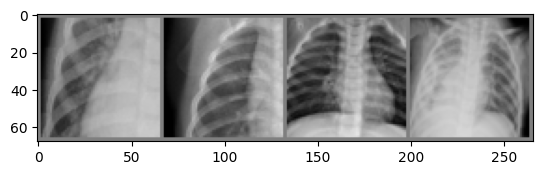

In [116]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

# print labels
print(' '.join('%14s' % classes[labels[j]] for j in range(4)))

You have to construct the CNN and experiment with different configurations so that you obtain the best performance.

In [129]:
class ChestXrayConvNet(nn.Module):
    def __init__(self):
        super(ChestXrayConvNet, self).__init__()

        # TODO - write conv layers and pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # TODO - write linear layers
        self.fc1 = nn.Linear(in_features=16 * 13 * 13, out_features=240)
        self.fc2 = nn.Linear(in_features=240, out_features=168)
        self.fc3 = nn.Linear(in_features=168, out_features=2)

        # TODO - Activation function - Do not forget to use it in forward function after conv and linear layers
        self.activation = nn.ReLU()

    def forward(self, x):
        ### Convolutional Part

        # TODO - write the pass through conv layers
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)

        # TODO - Flatten features for input to fully connected layers - Transform the features into 1D vector
        x = x.view(-1, 16 * 13 * 13)

        ### Fully connected part
        # TODO - write the pass through fully connected layers
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        return x

In [130]:
model = ChestXrayConvNet()
model.to(device)

ChestXrayConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2704, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=168, bias=True)
  (fc3): Linear(in_features=168, out_features=2, bias=True)
  (activation): ReLU()
)

In [131]:
# TODO - Choose Hyperparameters - these ones may not be good
learning_rate = 0.00015
epochs = 30

# Loss - dependinng on the task you should change this
criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [132]:
run_training(model, criterion, optimizer, epochs)

100%|██████████| 5/5 [00:00<00:00,  7.00it/s, Epoch=0, Valid_Acc=62.2, Valid_Loss=0.7] 
Validation Accuracy Improved (0.0 ---> 62.19)

100%|██████████| 5/5 [00:00<00:00,  7.20it/s, Epoch=1, Valid_Acc=62.2, Valid_Loss=0.61]

100%|██████████| 5/5 [00:00<00:00,  7.09it/s, Epoch=2, Valid_Acc=63.8, Valid_Loss=0.58]
Validation Accuracy Improved (62.19 ---> 63.75)

100%|██████████| 5/5 [00:00<00:00,  7.15it/s, Epoch=3, Valid_Acc=73.6, Valid_Loss=0.52]
Validation Accuracy Improved (63.75 ---> 73.59)

100%|██████████| 5/5 [00:00<00:00,  7.03it/s, Epoch=4, Valid_Acc=80.3, Valid_Loss=0.48]
Validation Accuracy Improved (73.59 ---> 80.31)

100%|██████████| 5/5 [00:00<00:00,  6.59it/s, Epoch=5, Valid_Acc=77.2, Valid_Loss=0.47]

100%|██████████| 5/5 [00:00<00:00,  7.15it/s, Epoch=6, Valid_Acc=79.7, Valid_Loss=0.46]

100%|██████████| 5/5 [00:00<00:00,  6.55it/s, Epoch=7, Valid_Acc=78.3, Valid_Loss=0.46]

100%|██████████| 5/5 [00:00<00:00,  6.34it/s, Epoch=8, Valid_Acc=78, Valid_Loss=0.48]  

100%|████

KeyboardInterrupt: 

#### Problems

In Deep Learning we are usually confronted with imbalanced datasets where some classes appear more frequently than others.
- Notice that Pneumonia Images appear more frequently than normal ones in both training and testing
- Accuracy may not be a good metric in this case. What accuracy will have a model that only predicts pneumonia? What metric should we use?
- The model will see 3 times more training samples with pneumonia. It may learn to predict that pneumonia is more likely without actually looking for relevant cues in the image.

Research what evaluation metrics to use for classification when the testing set is imbalanced.

Research how we can improve the training when the training data is imbalanced.